In [1]:
# Cell 3.1 (updated): Load Proxy Heston Parameters into heston_params Dict

import os
import pandas as pd
import numpy as np

# Try a couple of common locations for the CSV
candidates = [
    "proxy_heston.csv",
    "/mnt/data/proxy_heston.csv"
]
for path in candidates:
    if os.path.exists(path):
        csv_path = path
        break
else:
    raise FileNotFoundError(
        "Could not find proxy_heston.csv in the current directory "
        "or /mnt/data. Please move it there or update the path."
    )

# Read the CSV
proxy_df = pd.read_csv(csv_path)

# Build the same heston_params structure your calibration cell uses
heston_params = {}
for _, row in proxy_df.iterrows():
    sym = row["Ticker_PROXY"]
    theta = np.array([
        row["kappa"],
        row["theta_var"],
        row["xi"],
        row["rho"],
        row["v0"]
    ])
    params_series = pd.Series(theta, index=["kappa","theta_var","xi","rho","v0"])
    # Since these are proxies, we don’t have an RMSE
    heston_params[sym] = {"params": params_series, "rmse": np.nan}

# (Optional) Display what you loaded
print("Loaded proxy parameters for tickers:")
print(", ".join(heston_params.keys()))


Loaded proxy parameters for tickers:
AAPL_PROXY, XOM_PROXY, JPM_PROXY, PG_PROXY, JNJ_PROXY, CAT_PROXY, BHP_PROXY, NEE_PROXY


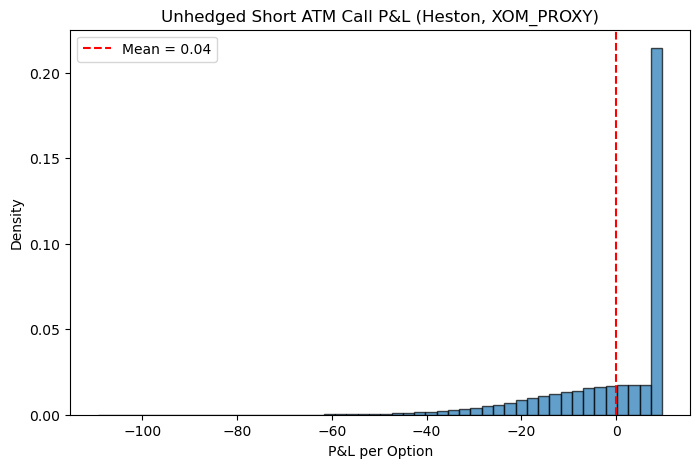


Short Call P&L Statistics (XOM_PROXY):
                  Value
Initial Price    9.6979
Mean P&L         0.0438
Std P&L         13.2817
Min P&L       -109.2270
Max P&L          9.6979
VaR(95%)        27.4392
CVaR(95%)       36.7071


In [2]:
# Cell 7 (fixed): Unhedged Short Call P&L under Heston via heston_path_sim

import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# ensure we can import your helper
proj_path = os.getcwd()
if proj_path not in sys.path:
    sys.path.append(proj_path)

from important_functions import heston_path_sim, heston_call

# 1) Proxy parameters for XOM_PROXY
theta   = heston_params["XOM_PROXY"]["params"]
kappa   = theta["kappa"]
theta_v = theta["theta_var"]
xi      = theta["xi"]
rho     = theta["rho"]
v0      = theta["v0"]

# 2) Contract & sim settings
S0       = 100.0     # initial spot
K        = S0        # ATM strike
r0       = 0.01      # risk-free rate
T        = 1.0       # 1 year to expiry
N_steps  = 252       # simulation time steps
n_sims   = 200_000     # Monte Carlo paths

# 3) Heston analytic call price at t=0
C0 = heston_call(S0, K, v0, r0, T, kappa, theta_v, xi, rho)

# 4) Simulate price paths (no hedging)
#    Signature: heston_path_sim(S0, v0, r, t, n_steps,
#                                kappa, theta, xi, rho,
#                                n_sims, mu, return_vol)
paths = heston_path_sim(
    S0,      # initial spot
    v0,      # initial variance
    r0,      # risk-free rate
    T,       # total time
    N_steps, # number of steps
    kappa,
    theta_v,
    xi,
    rho,
    n_sims,  # number of paths
    mu=0.0,  # drift term in SDE, usually zero under risk-neutral
    return_vol=False
)
# `paths` shape: (n_sims, N_steps+1)

# 5) Compute unhedged P&L
S_T   = paths[:, -1]
pay   = np.maximum(S_T - K, 0)          # call payoff at expiry
pnl   = C0 - np.exp(-r0 * T) * pay      # discounted payoff

# 6) Plot distribution
plt.figure(figsize=(8,5))
plt.hist(pnl, bins=50, density=True, alpha=0.7, edgecolor='k')
plt.title('Unhedged Short ATM Call P&L (Heston, XOM_PROXY)')
plt.xlabel('P&L per Option')
plt.ylabel('Density')
plt.axvline(pnl.mean(), color='red', linestyle='--',
            label=f"Mean = {pnl.mean():.2f}")
plt.legend()
plt.show()

# 7) Summary statistics
stats = pd.Series({
    "Initial Price": round(C0, 4),
    "Mean P&L":      round(pnl.mean(), 4),
    "Std P&L":       round(pnl.std(), 4),
    "Min P&L":       round(pnl.min(), 4),
    "Max P&L":       round(pnl.max(), 4),
    "VaR(95%)":      round(-np.percentile(pnl, 5), 4),
    "CVaR(95%)":     round(-pnl[pnl <= np.percentile(pnl,5)].mean(), 4)
})
print("\nShort Call P&L Statistics (XOM_PROXY):")
print(stats.to_frame("Value"))


Chunks (of 10000): 100%|#########################################################| 10000/10000 [01:45<00:00, 94.68it/s]


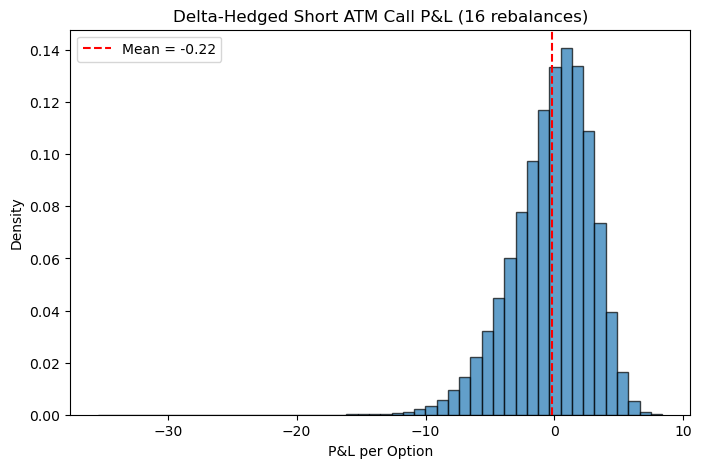


Delta‐Hedged Short Call P&L Stats (XOM_PROXY):
                Value
Initial Price  9.6979
Mean P&L      -0.2236
Std P&L        3.0386
VaR (95%)      5.7573
CVaR (95%)     7.6005


In [15]:
# Cell 8: Delta‐Hedged Short Call P&L via heston_call_MC with ASCII progress bar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from important_functions import heston_call, heston_call_MC

# --------------------------------------------------------------------
# 1) Load proxy Heston parameters for XOM_PROXY
# --------------------------------------------------------------------
theta   = heston_params["XOM_PROXY"]["params"]
kappa   = theta["kappa"]
theta_v = theta["theta_var"]
xi      = theta["xi"]
rho     = theta["rho"]
v0      = theta["v0"]

# --------------------------------------------------------------------
# 2) Contract & simulation settings
# --------------------------------------------------------------------
S0       = 100.0       # initial stock price
K        = S0          # ATM strike
r0       = 0.01        # annual risk-free rate
T        = 1.0         # time to expiry (years)
n_hedges = 16         # number of rebalancings
n_sims   = 2_000_000   # total Monte Carlo paths
chunk    = 200     # paths per chunk

# --------------------------------------------------------------------
# 3) Compute initial Heston model call price
# --------------------------------------------------------------------
C0 = heston_call(S0, K, v0, r0, T, kappa, theta_v, xi, rho)

# --------------------------------------------------------------------
# 4) Simulate delta‐hedged payoffs in batches with progress bar
# --------------------------------------------------------------------
payoffs_list = []
n_chunks = n_sims // chunk
for _ in tqdm(range(n_chunks), desc=f"Chunks (of {n_chunks})", ascii=True):
    pay_chunk = heston_call_MC(
        S0, K, v0, r0, T,
        n_hedges,
        kappa, theta_v, xi, rho,
        n_sims=chunk
    )
    payoffs_list.append(pay_chunk)

# handle remainder if any
rem = n_sims % chunk
if rem:
    payoffs_list.append(
        heston_call_MC(
            S0, K, v0, r0, T,
            n_hedges,
            kappa, theta_v, xi, rho,
            n_sims=rem
        )
    )

payoffs_hedged = np.concatenate(payoffs_list)

# --------------------------------------------------------------------
# 5) Seller P&L: premium received minus hedged payoffs
# --------------------------------------------------------------------
pnl = C0 - payoffs_hedged

# --------------------------------------------------------------------
# 6) Plot distribution of delta‐hedged P&L
# --------------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.hist(pnl, bins=50, density=True, alpha=0.7, edgecolor='k')
plt.title(f'Delta‐Hedged Short ATM Call P&L ({n_hedges} rebalances)')
plt.xlabel('P&L per Option')
plt.ylabel('Density')
plt.axvline(pnl.mean(), color='red', linestyle='--',
            label=f"Mean = {pnl.mean():.2f}")
plt.legend()
plt.show()

# --------------------------------------------------------------------
# 7) Summary statistics
# --------------------------------------------------------------------
stats = pd.Series({
    "Initial Price": round(C0,        4),
    "Mean P&L":      round(pnl.mean(),4),
    "Std P&L":       round(pnl.std(), 4),
    "VaR (95%)":     round(-np.percentile(pnl, 5), 4),
    "CVaR (95%)":    round(-pnl[pnl <= np.percentile(pnl,5)].mean(), 4)
})

print("\nDelta‐Hedged Short Call P&L Stats (XOM_PROXY):")
print(stats.to_frame("Value"))


Hedge steps: 100%|#######################################################################| 8/8 [00:44<00:00,  5.60s/it]


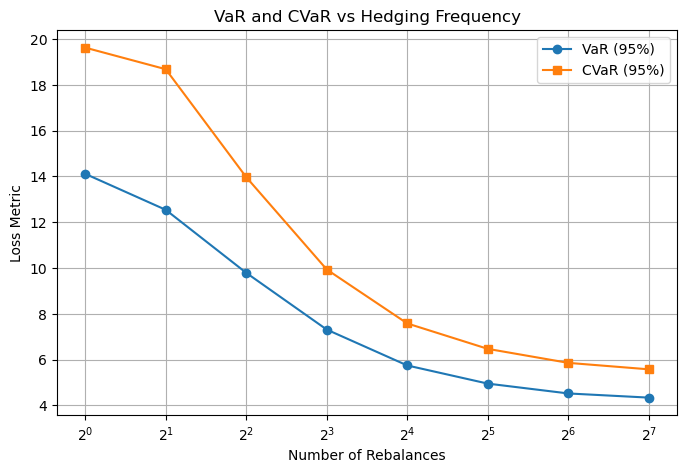


P&L Statistics by Hedging Frequency:
           Min P&L  Max P&L  VaR(95%)  CVaR(95%)
n_hedges                                        
1         -69.4350   9.1357   14.1134    19.6251
2        -127.2214   9.1430   12.5423    18.6822
4         -64.5881   9.2524    9.7899    13.9687
8         -37.3568   9.0818    7.3118     9.9360
16        -26.6820   8.0869    5.7454     7.5801
32        -18.9513   7.6693    4.9529     6.4701
64        -16.0816   6.6642    4.5234     5.8586
128       -14.3331   6.3168    4.3413     5.5767


In [9]:
# Cell 8: Impact of Hedging Frequency on P&L Statistics

import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# ensure helper import path
proj_path = os.getcwd()
if proj_path not in sys.path:
    sys.path.append(proj_path)

from important_functions import heston_call, heston_call_MC

# --------------------------------------------------------------------
# 1) Load proxy Heston parameters for XOM_PROXY
# --------------------------------------------------------------------
theta   = heston_params["XOM_PROXY"]["params"]
kappa   = theta["kappa"]
theta_v = theta["theta_var"]
xi      = theta["xi"]
rho     = theta["rho"]
v0      = theta["v0"]

# --------------------------------------------------------------------
# 2) Contract & sim settings
# --------------------------------------------------------------------
S0     = 100.0      # initial stock price
K      = S0         # ATM strike
r0     = 0.01       # annual risk-free rate
T      = 1.0        # time to expiry (years)
n_sims = 200_000    # Monte Carlo paths per run

# hedging frequencies to test
hedge_list = [1, 2, 4, 8, 16, 32, 64, 128]

# prepare storage for stats
stats_list = []

# --------------------------------------------------------------------
# 3) Compute initial Heston call premium once
# --------------------------------------------------------------------
C0 = heston_call(S0, K, v0, r0, T, kappa, theta_v, xi, rho)

# --------------------------------------------------------------------
# 4) Loop over hedging frequencies
# --------------------------------------------------------------------
for n_hedges in tqdm(hedge_list, desc="Hedge steps", ascii=True):
    # simulate delta-hedged payoffs
    payoffs = heston_call_MC(
        S0, K, v0, r0, T,
        n_hedges,
        kappa, theta_v, xi, rho,
        n_sims=n_sims
    )
    pnl = C0 - payoffs

    # compute key statistics
    stats_list.append({
        'n_hedges': n_hedges,
        'Min P&L':   round(np.min(pnl),    4),
        'Max P&L':   round(np.max(pnl),    4),
        'VaR(95%)':  round(-np.percentile(pnl, 5), 4),
        'CVaR(95%)': round(-pnl[pnl <= np.percentile(pnl,5)].mean(), 4)
    })

# --------------------------------------------------------------------
# 5) Build DataFrame of results
# --------------------------------------------------------------------
stats_df = pd.DataFrame(stats_list).set_index('n_hedges')


# 6) Plot VaR and CVaR vs hedging frequency
plt.figure(figsize=(8,5))
plt.plot(stats_df.index, stats_df['VaR(95%)'], marker='o', label='VaR (95%)')
plt.plot(stats_df.index, stats_df['CVaR(95%)'], marker='s', label='CVaR (95%)')
plt.xscale('log', base=2)           # ← use `base` instead of `basex`
plt.xlabel('Number of Rebalances')
plt.ylabel('Loss Metric')
plt.title('VaR and CVaR vs Hedging Frequency')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------------------------
# 7) Display stats table
# --------------------------------------------------------------------
print("\nP&L Statistics by Hedging Frequency:")
print(stats_df.to_string())


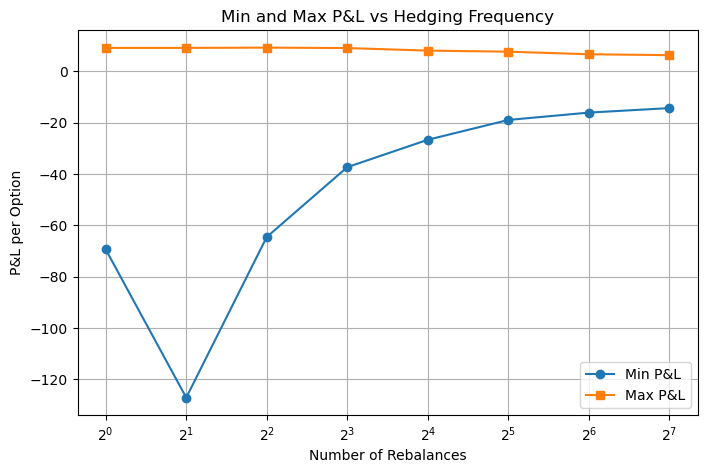

In [10]:
# Cell 8b: Plot Min and Max P&L vs Hedging Frequency

plt.figure(figsize=(8,5))
plt.plot(stats_df.index, stats_df['Min P&L'], marker='o', label='Min P&L')
plt.plot(stats_df.index, stats_df['Max P&L'], marker='s', label='Max P&L')
plt.xscale('log', base=2)
plt.xlabel('Number of Rebalances')
plt.ylabel('P&L per Option')
plt.title('Min and Max P&L vs Hedging Frequency')
plt.legend()
plt.grid(True)
plt.show()
